In [7]:
pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-7bslruut
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-7bslruut
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 4.3MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33791 sha256=63b1d78ad619e2103122871d7143b4f92cc53c06fea41cc8d95e621c77a73030
  Stored in directory: /tmp/pip-ephem-wheel-cache-0j2gq0fh/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [1]:
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

In [2]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

In [3]:
ds, ds_info = tfds.load('tf_flowers', split='train', with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


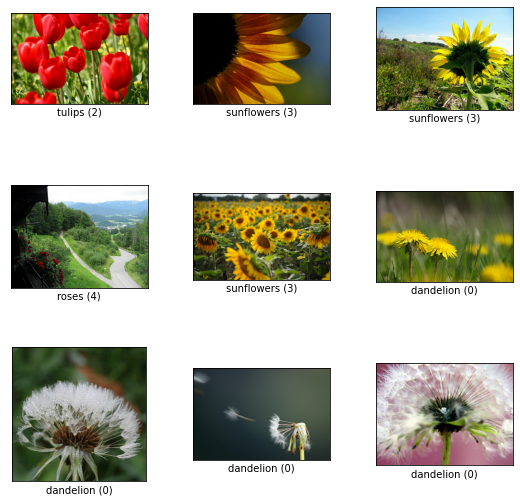

In [4]:
fig = tfds.show_examples(ds, ds_info)

In [5]:
!rm -rf images
!mkdir images

In [8]:
from absl import logging

from tensorflow_datasets.core import dataset_utils
from tensorflow_datasets.core import features as features_lib
from PIL import Image
from efficientnet.preprocessing import center_crop_and_resize


def save_examples(ds_info, ds, num_examples = 10, folder=".", image_key=None):
  if not image_key:
    # Infer the image and label keys
    image_keys = [
        k for k, feature in ds_info.features.items()
        if isinstance(feature, features_lib.Image)
    ]

    if not image_keys:
      raise ValueError(
          "Visualisation not supported for dataset `{}`. Was not able to "
          "auto-infer image.".format(ds_info.name))

    if len(image_keys) > 1:
      raise ValueError(
          "Multiple image features detected in the dataset. Using the first one. You can "
          "use `image_key` argument to override. Images detected: %s" %
          (",".join(image_keys)))

    image_key = image_keys[0]

  label_keys = [
      k for k, feature in ds_info.features.items()
      if isinstance(feature, features_lib.ClassLabel)
  ]
  label_key = label_keys[0] if len(label_keys) == 1 else None
  if not label_key:
    logging.info("Was not able to auto-infer label.")

  examples = list(dataset_utils.as_numpy(ds.take(num_examples)))

  for i, ex in enumerate(examples):
    if not isinstance(ex, dict):
      raise ValueError(
          "tfds.show_examples requires examples as `dict`, with the same "
          "structure as `ds_info.features`. It is currently not compatible "
          "with `as_supervised=True`. Received: {}".format(type(ex)))

    # Plot the image
    image = ex[image_key]
    if len(image.shape) != 3:
      raise ValueError(
          "Image dimension should be 3. tfds.show_examples does not support "
          "batched examples or video.")
    _, _, c = image.shape
    if c == 1:
      image = image.reshape(image.shape[:2])
    image = center_crop_and_resize(image, 224).astype(np.uint8)
    im = Image.fromarray(image)
    # Plot the label
    if label_key:
      label = ex[label_key]
      label_str = ds_info.features[label_key].int2str(label)
    else:
      label_str = ""
    im.save(f"{folder}/image_{label_str}_{i}.jpeg")

save_examples(ds_info, ds, 1000, "images")

In [9]:

!du -hs images

14M	images


In [ ]:
!pip install efficientnet

In [10]:

import tensorflow as tf
import numpy as np
import time

from efficientnet.tfkeras import EfficientNetB0
import numpy as np
import pyarrow.parquet as pq
import pyarrow as pa


def list_files(images_path):
    return tf.data.Dataset.list_files(images_path + '/*', shuffle=False).cache()


def process_path(file_path):
    parts = tf.strings.split(file_path, '/')
    image_name = tf.strings.split(parts[-1], '.')[0]
    raw = tf.io.read_file(file_path)
    return raw, image_name


def read_data_from_files(list_ds):
    return list_ds.map(process_path,
                       num_parallel_calls=tf.data.experimental.AUTOTUNE)#.apply(tf.data.experimental.ignore_errors())


def images_to_embeddings(model, dataset, batch_size):
    return model.predict(dataset.batch(batch_size).map(lambda image_raw, image_name: image_raw), verbose=1)
    
def save_embeddings_ds_to_parquet(embeddings, dataset, path):
    embeddings = pa.array(embeddings.tolist(), type=pa.list_(pa.float32()))
    image_names = pa.array(dataset.map(lambda image_raw, image_name: image_name).as_numpy_iterator())
    table = pa.Table.from_arrays([image_names, embeddings], ["image_name", "embedding"])
    pq.write_table(table, path)


def compute_save_embeddings(list_ds, folder, num_shards, model, batch_size):
    start = time.time()
    for shard_id in range(0, num_shards):
        shard_list = list_ds.shard(num_shards=num_shards, index=shard_id)
        shard = read_data_from_files(shard_list)
        embeddings = images_to_embeddings(model, shard, batch_size)
        print("Shard " + str(shard_id) + " done after " + str(int(time.time() - start)) + "s")
        save_embeddings_ds_to_parquet(embeddings, shard,
                                      folder + "/part-" + "{:03d}".format(shard_id) + ".parquet")
        print("Shard " + str(shard_id) + " saved after " + str(int(time.time() - start)) + "s")
    print("Total time : " + str(int(time.time() - start)))


def run_inference(image_folder, output_folder, num_shards=100, batch_size=1000):
    model = EfficientNetB0(weights='imagenet', include_top=False, pooling="avg")
    list_ds = list_files(image_folder)
    compute_save_embeddings(list_ds, output_folder, num_shards, model, batch_size)

In [11]:
from efficientnet.tfkeras import EfficientNetB0
import tensorflow as tf
import numpy as np
import time


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(image, image_name):
    feature = {
        'image_name': _bytes_feature(image_name),
        'image': _bytes_feature(image)
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


def tf_serialize_example(image, image_name):
    tf_string = tf.py_function(
        serialize_example,
        (image, image_name),
        tf.string)
    return tf.reshape(tf_string, ())


def process_path(file_path):
    parts = tf.strings.split(file_path, '/')
    image_name = tf.strings.split(parts[-1], '.')[0]
    raw = tf.io.read_file(file_path)
    return raw, image_name


def read_image_file_write_tfrecord(files_ds, output_filename):
    image_ds = files_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    serialized_features_dataset = image_ds.map(tf_serialize_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    writer = tf.data.experimental.TFRecordWriter(output_filename)
    writer.write(serialized_features_dataset)

def image_files_to_tfrecords(list_ds, output_folder, num_shard):
    start = time.time()
    for shard_id in range(0, num_shard):
        shard_list = list_ds.shard(num_shards=num_shard, index=shard_id)
        read_image_file_write_tfrecord(shard_list, output_folder + "/part-" + "{:03d}".format(shard_id) + ".tfrecord")
        print("Shard " + str(shard_id) + " saved after " + str(int(time.time() - start)) + "s")


feature_description = {
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string)
}


def _parse_function(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)


def preprocess_image(d):
    image_name = d['image_name']
    raw = d['image']
    image = tf.image.decode_jpeg(raw)
    image = tf.image.convert_image_dtype(image, tf.float32)

    return image, image_name

def read_tfrecord(filename):
    filenames = [filename]
    raw_dataset = tf.data.TFRecordDataset(filenames)
    return raw_dataset \
        .map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .apply(tf.data.experimental.ignore_errors())


def tfrecords_to_write_embeddings(tfrecords_folder, output_folder, model, batch_size):
    tfrecords = [f.numpy().decode("utf-8") for f in \
                 tf.data.Dataset.list_files(tfrecords_folder + "/*.tfrecord", shuffle=False)]
    start = time.time()
    for shard_id, tfrecord in enumerate(tfrecords):
        shard = read_tfrecord(tfrecord)
        embeddings = images_to_embeddings(model, shard, batch_size)
        print("")
        print("Shard " + str(shard_id) + " done after " + str(int(time.time() - start)) + "s")
        save_embeddings_ds_to_parquet(embeddings, shard,
                                      output_folder + "/part-" + "{:03d}".format(shard_id) + ".parquet")
        print("Shard " + str(shard_id) + " saved after " + str(int(time.time() - start)) + "s")

In [12]:
def write_tfrecord(image_folder, output_folder, num_shards=100):
    list_ds = list_files(image_folder)
    image_files_to_tfrecords(list_ds, output_folder, num_shards)

In [13]:
!rm -rf tfrecords
!mkdir tfrecords

In [13]:

write_tfrecord("images", "tfrecords", 1)

Shard 0 saved after 0s


In [14]:
!du -h -s tfrecords

4.0K	tfrecords


In [15]:

!rm -rf embeddings
!mkdir embeddings

In [16]:
from efficientnet.tfkeras import EfficientNetB0


def run_inference(tfrecords_folder, output_folder, batch_size=1000):
    model = EfficientNetB0(weights='imagenet', include_top=False, pooling="avg")
    tfrecords_to_write_embeddings(tfrecords_folder, output_folder, model, batch_size)

In [ ]:
from tensorflow.keras.applications import VGG16

def run_inference(tfrecords_folder, output_folder, batch_size=1000):
 
  model = VGG16(weights = 'imagenet',include_top=False, pooling="avg")
  tfrecords_to_write_embeddings(tfrecords_folder, output_folder, model, batch_size)

In [17]:
run_inference("tfrecords", "embeddings", 1000)

1/1 [==============================] - 0s 66ms/step

Shard 0 done after 13s
Shard 0 saved after 14s


In [18]:

emb = pq.read_table("embeddings").to_pandas()

In [19]:
emb


,image_name,embedding
0,b'image_daisy_102',"[-0.03543875, -0.15163344, -0.13496658, -0.143..."
1,b'image_daisy_104',"[-0.15745674, -0.12783377, -0.17943212, -0.106..."
2,b'image_daisy_114',"[-0.17923637, -0.12422173, -0.16109546, -0.113..."
3,b'image_daisy_121',"[-0.10443417, -0.17378387, -0.12409487, -0.146..."
4,b'image_daisy_126',"[-0.08360679, -0.106588036, -0.16171135, -0.04..."
...,...,...
995,b'image_tulips_984',"[-0.15302733, -0.17486958, -0.102667645, -0.14..."
996,b'image_tulips_987',"[-0.08174772, -0.1298728, 0.07792735, -0.07462..."
997,b'image_tulips_989',"[-0.09315236, -0.19348022, -0.11206706, -0.121..."
998,b'image_tulips_993',"[-0.1454347, -0.14555837, -0.15405503, -0.1025..."


In [20]:
!du -hs embeddings

5.5M	embeddings


In [21]:
!pip install faiss_cpu

     |████████████████████████████████| 7.9MB 8.1MB/s 


In [22]:
id_to_name = {k:v.decode("utf-8") for k,v in enumerate(list(emb["image_name"]))}
name_to_id = {v:k for k,v in id_to_name.items()}

In [23]:
embgood = np.stack(emb["embedding"].to_numpy())
embgood

array([[-0.03543875, -0.15163344, -0.13496658, ...,  0.01907678,
        -0.13296673,  0.53734636],
       [-0.15745674, -0.12783377, -0.17943212, ...,  0.31157237,
        -0.11525831,  0.44805577],
       [-0.17923637, -0.12422173, -0.16109546, ...,  0.00203698,
        -0.20498401,  0.19341145],
       ...,
       [-0.09315236, -0.19348022, -0.11206706, ..., -0.17900701,
        -0.1336633 ,  0.84888476],
       [-0.1454347 , -0.14555837, -0.15405503, ..., -0.16430715,
        -0.00788506,  0.37932646],
       [-0.13419457, -0.10744529, -0.12787175, ..., -0.13693433,
        -0.0720928 ,  0.21788408]], dtype=float32)

In [24]:

!pip install -q ipyplot

In [25]:
import faiss
d = 1280
xb = embgood
index = faiss.IndexFlatIP(d)
index.add(xb)

In [26]:
def search(emb, k=5):
  D, I = index.search(np.expand_dims(emb, 0), k)     # actual search
  return list(zip(D[0], [id_to_name[x] for x in I[0]]))

In [27]:
from IPython.display import Image, display
from ipywidgets import widgets, HBox, VBox
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

def display_picture(image_name):
  display(Image(filename=f"images/{image_name}.jpeg"))

def display_results(results):
  hbox = HBox([VBox([widgets.Label(f"{distance:.2f} {image_name}"), widgets.Image(value=open(f"images/{image_name}.jpeg", 'rb').read())]) for distance, image_name in results])
  display(hbox)


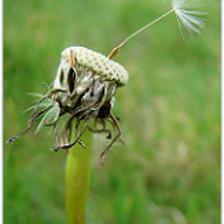

In [28]:
p = "image_dandelion_172"
display_picture(p)
display_results(search(xb[name_to_id[p]]))

image_roses_491


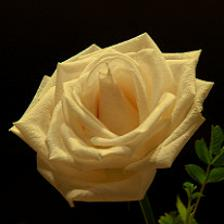

In [29]:
p = 500
print(id_to_name[p])
display_picture(id_to_name[p])
display_results(search(xb[p]))


In [30]:
from sklearn.neighbors import NearestNeighbors

In [53]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='kd_tree',metric='chebyshev').fit(embgood)
distances,indices = nbrs.kneighbors(embgood)

In [54]:
indices

array([[  0,  83, 580, 746, 755],
       [  1, 300, 645, 648, 395],
       [  2,  36,  72, 126,   9],
       ...,
       [997, 925, 880, 859, 889],
       [998, 605, 831, 517, 807],
       [999, 948, 883, 806, 801]])

In [55]:
distances

array([[0.        , 1.71194811, 1.77663867, 1.78911865, 1.81918713],
       [0.        , 1.78023839, 1.83259511, 1.83732458, 1.84220831],
       [0.        , 0.84329683, 1.0396055 , 1.16672951, 1.18801802],
       ...,
       [0.        , 1.45494142, 1.48327082, 1.52790102, 1.53534251],
       [0.        , 1.39050072, 1.58939219, 1.73502582, 1.75550476],
       [0.        , 1.47101368, 1.59527004, 1.65519168, 1.67967999]])

In [60]:

def similar_images(p,metric):
  print("Results for",metric, " metric")
  nbrs = NearestNeighbors(n_neighbors=5, algorithm='kd_tree',metric=metric).fit(embgood)
  distances,indices = nbrs.kneighbors(embgood)
  for i in range(len(indices)):
    if(p == indices[i][0]):
      print(id_to_name[p])
      display_picture(id_to_name[p])
      for j in range(1,5):
        print(id_to_name[indices[i][j]])
        display_picture(id_to_name[indices[i][j]])
  return


    

   

Results for euclidean  metric
image_roses_491


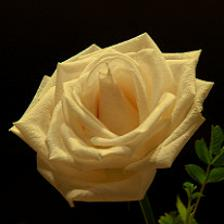

image_roses_461


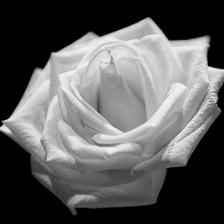

image_roses_733


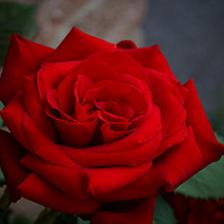

image_roses_576


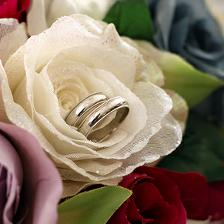

image_roses_992


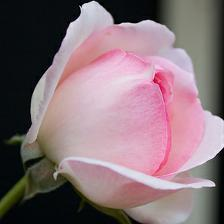

In [61]:
p =500
metric = "euclidean"
similar_images(p,metric)

Results for chebyshev  metric
image_roses_491


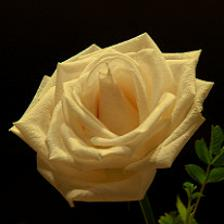

image_roses_461


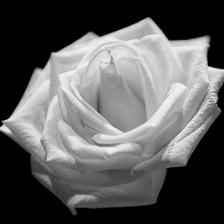

image_roses_733


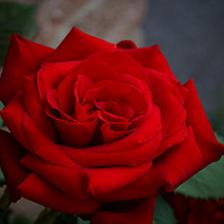

image_roses_426


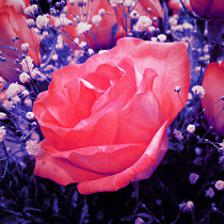

image_roses_600


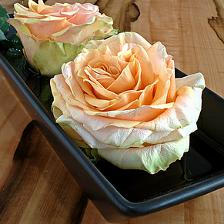

In [58]:
p =500
metric = "chebyshev"
similar_images(p,metric)

Results for manhattan  metric
image_roses_491


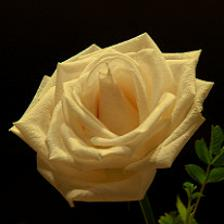

image_roses_461


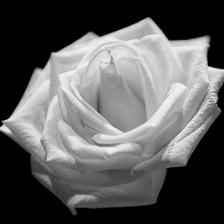

image_roses_733


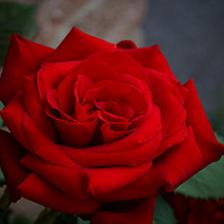

image_roses_726


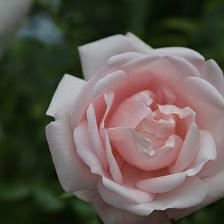

image_tulips_267


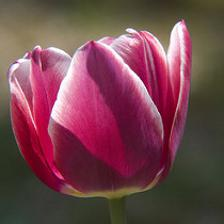

In [62]:
p =500
metric = "manhattan"
similar_images(p,metric)